# Social synchronization of conditioned fear in mice requires ventral hippocampus input to amygdala
Running title: Emotional synchronization in mice<BR>
Wataru Ito*, Alexei Morozov*

*This document describes the codes in the manuscript and how to run them using an example video, according to **the nature portfolio, Reporting Summary, and Software and code**.
    
# Set up the Python environment
Conda and pip configured the Python environment. We describe here solely the installation on Windows 10 PC. The lines preceded by # are comment lines.

#### 1. Install Miniconda
Download the binary and install it as described on the web<BR>
https://docs.conda.io/en/latest/miniconda.html#windows-installers
    
#### 2. Open the Anaconda prompt and follow the sequence below.
```python
# anaconda, python 3.8 for MATLAB engine for python
conda update -n base -c defaults conda
conda create --name jl2
conda activate jl2
conda install python=3.8 anaconda
```
    
```python    
# matplotlib
# The following command request installation of node.js
# Download Nodo.js https://nodejs.org/en/download/<BR>
# Install https://github.com/nodejs/help/wiki/Installation
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install jupyter-matplotlib
jupyter nbextension list
```

```python 
# Install other packages
# for video process
pip install opencv-contrib-python
pip install ffmpeg-python
```

#### 3. Download the codes and start Jupyter Lab
1. Go to https://github.com/wataruito/Codes_in_Emotional_sync_Ito_et_al
2. Select the "Code/Download ZIP"
    
<img src="img/Screenshot 2021-11-10 145736.png" width=400px><BR>
    
3. Extract the downloaded zip file.
4. Place the `Codes_in_Emotional_sync_Ito_et_al-main` folder to an appropriate place.


#### 4. In the opened the Anaconda prompt   
1. Change the current directory into the `Codes_in_Emotional_sync_Ito_et_al-main` folder.
2. Start Jupyter Lab.
    
```python
jupyter lab python_codes_in_manuscript.ipynb
```
    
Follow "1. Set the root path" in the opened notebook.

---
# 1. Set the root path
Set the current path as an absolute path.

In [1]:
# This is a example. You need to specify the root path.
# If you clone in C:/Users/User
# root_path = path = r'C:\Users\User\Codes_in_Emotional_sync_Ito_et_al'
root_path = path = r'W:\wataru\jupyter\synchro_freeze\Codes_in_Emotional_sync_Ito_et_al'

# 2. Convert Freezeframe video to mp4 format
#### 1. Export AVI file using FreezeFrame Viewer
    1) install FreezeFrameInstaller4104.zip
    2) in FreezeFrame Viewer
        Video/Compress Image Files, as AVI file, using MJPEG Compressor
#### Or copy `m7ab.avi` file from `backup_videos\exp1` to `videos\exp1`
`backup_videos\exp1` folder contains all processed data to be done by the python scripts.

#### 2. Convert avi to mp4
The following script rotates and converts all AVI videos inside the specified folder.

In [4]:
# Specify Windows path of the folder, which has the exported avi files.
r_path = r'videos\exp1'

import os
import ffmpeg

path = os.path.join(root_path, r_path)
os.chdir(path)
print(os.listdir(path))

for file in os.listdir(path):
    base = os.path.splitext(file)[0]
    extn = os.path.splitext(file)[1]
    if extn == '.avi':
        # !ffmpeg -i {file} -vf "transpose=2,transpose=2" -vcodec libx264 {base}.mp4
        fileIN = os.path.join(path,file)
        print('file = ', fileIN, end = ' ')
        stream = ffmpeg.input(fileIN)
        stream = ffmpeg.hflip(stream)
        stream = ffmpeg.vflip(stream)
        fileOUT = os.path.join(path,base) + '.mp4'
        print('---> output = ', fileOUT)
        stream = ffmpeg.output(stream, fileOUT, vcodec='libx264')
        ffmpeg.run(stream)
print('end')

['m7ab.avi', 'm7ab.csv', '_m7ab_freeze.csv', '_m7ab_track_freeze.csv']
file =  W:\wataru\jupyter\synchro_freeze\Codes_in_Emotional_sync_Ito_et_al\videos\20190408_testing_2\m7ab.avi ---> output =  W:\wataru\jupyter\synchro_freeze\Codes_in_Emotional_sync_Ito_et_al\videos\20190408_testing_2\m7ab.mp4
end


In this case, it generates `videos\exp1\m7ab.mp4`.

# 3. Manual annotation of videos for the onset and offset of freezing 

Videoplay is designed as an interactive video annotator through keyboard inputs. For example, a user can move forward and backward the movie frames, select the target subject to be annotated, and mark each freezing bout with the starting and ending video frames. 

**Short description of keyboard controls:**
```
<Video control>
w: start palying
s: stop playing
a: step back a frame
d: step forward a frame
A: step back <frame_jump> frames
D: step forward <frame_jump> frames
~: set <frame_jump> parameter
q: increase playback speed
e: decrease playback speed

<Tracking trajectories>
0: drug mode
1: sub1 click mode
2: sub2 click mode

<Annotate freezing>
!: set target sub1
@: set target sub2
j: start freezing
k: end freezing
    
<Quit>
Esc
````



In [6]:
import videoplay as vp

# Specify Windows path of the MP4 movie file.
r_path = r'videos\20190408_testing_2\m7ab.mp4'
path = os.path.join(root_path, r_path)

vp.video_cursor(path,3)

Video resolution: (236, 304, 3)
total frame number: 722
	Reading _m7ab_track_freeze.csv
	Writing _m7ab_track_freeze.csv
	Writing _m7ab_freeze.csv


After quitting Videoplay by Esc key, it generates `videos\exp1\_m7ab_track_freeze.csv` and `videos\exp1\_m7ab_freeze.csv`.

# 4. Manually modify the output CSV files from Videoplay
The Videoplay outputs a csv file, `videos\exp1\_m7ab_freeze.csv`. It looks as follows.<BR>
    
<img src="img/Screenshot 2021-07-13 185614.png" width=400px><BR>

Modify the csv file  manually as below and save as `videos\exp1\m7ab_freeze.csv`.
       
<img src="img/Screenshot 2021-07-13 193140.png" width=400px><BR>

# 5. Compute freezing duration for each animal and freezing overlap for each dyad.

The following script processes all cvs files inside the specified folder.
Specify the path to the root folder, which contains multiple experiment folders. Each experiment folder
contains the CSV files, including the freezing onset and offset for two subjects as described in 4.

In [2]:
import synchro_freeze as sf
import traceback
import os

# Specify Windows path of the parent folder for experiments.
r_path = r'videos'
path = os.path.join(root_path, r_path)

DEBUG = False
df = sf.process_freeze(path,DEBUG)

Step1. Reading CSV files from subfolders.
	Processing directory:  exp1,  completed.
	Writing summary.csv.
Step2. Reading trajectory CSV files from subfolders.
	Processing directory:  exp1,  completed.
	Writing summary_traj.csv.
Step3. Computing % epoch time.
	Writing summary1.csv.
Step4. Computing permutation/Cohen_D and store in DF.
	Processing column:  0/1,  completed.
	Writing summary2.csv.


The script generates `videos\summary2.csv`. Output format is as follows.

|folder_videoname|single_animal|video_system|video_total_frames|fz_start_sub1|fz_end_sub1|fz_start_sub2|fz_end_sub2|fz_sub1|fz_sub2|fz_overlap|cohen_d|
|---|---|---|---|---|---|---|---|---|---|---|---|
|str|bool|str|int|int array|int array|int array|int array|float|float|float|float|

|column label|description|
|-|-|
fz_start_sub1, fz_start_sub2|freezing onset frame number|
fz_end_sub1, fz_end_sub2|freezing offset frame number|
fz_sub1, fz_sub2|% freezing time|
fz_overlap|% freezing overlap time|
cohen_d|Cohen's D effect size|






# 6. Display freezing overlap in specific experiment
### Resulting figure will be output as overlap_fig.eps

In [3]:
print("We found the following Foldername_videoname.\n")
for i in range (0, len(df)):
    print("\t", i, df.iloc[i,0])

print("\nSelect the Foldername_videoname ID number and run the next cell")

We found the following Foldername_videoname.

	 0 exp1_m7ab

Select the Foldername_videoname ID number and run the next cell


Folder name: exp1_m7ab
Animal1 freeze : 22.291667
Animal2 freeze : 51.250000
Overlap freeze : 20.000000


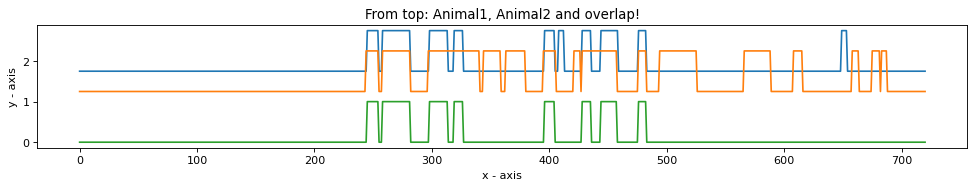

In [6]:
folderID = 0
output = True
video_system = 'FreezeFrame'

(a,b,c,d) = sf.overlap_freezing(df.iloc[folderID,:], path, output)

This script generate eps file, `videos\exp1\overlap_fig.eps`.